## **Dataset Used:** Google Web Graph

https://www.kaggle.com/datasets/pappukrjha/google-web-graph

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('web-Google-shorter.txt', sep='\t', comment='#', names=['Source', 'Target'])

# Display the first few rows of the dataset
data.head()

,Source,Target
0,0,11342
1,0,824020
2,0,867923
3,0,891835
4,11342,0


In [ ]:
# Basic statistics and information about the dataset
info = {
    "Number of Rows": len(data),
    "Number of Unique Sources": data['Source'].nunique(),
    "Number of Unique Targets": data['Target'].nunique(),
    "Number of Unique Nodes": len(set(data['Source']).union(set(data['Target']))),
    "Missing Values in Source": data['Source'].isnull().sum(),
    "Missing Values in Target": data['Target'].isnull().sum()
}

info

{'Number of Rows': 99996,
 'Number of Unique Sources': 8922,
 'Number of Unique Targets': 39600,
 'Number of Unique Nodes': 40304,
 'Missing Values in Source': 0,
 'Missing Values in Target': 0}

In [ ]:
reduced_data = data.sample(frac=0.1, random_state=42)
reduced_data.head()

,Source,Target
33968,486434,783512
24612,399337,455826
42677,576912,500687
9732,360463,393160
7129,759848,702328


In [ ]:
# Compute the out-degree for each source node
out_degree = reduced_data['Source'].value_counts()

# Compute the in-degree for each target node
in_degree = reduced_data['Target'].value_counts()

# Combine in-degree and out-degree to get the total degree for each node
total_degree = (out_degree + in_degree).fillna(0).astype(int)

# Get nodes with top 5 highest degrees and bottom 5 lowest degrees (excluding nodes with 0 degree)
top_5_nodes = total_degree.sort_values(ascending=False).head(5)
bottom_5_nodes = total_degree[total_degree > 0].sort_values().head(5)

top_5_nodes, bottom_5_nodes

(305229    38
 915273    20
 575171    19
 32163     17
 357952    17
 dtype: int64,
 1         2
 421117    2
 422877    2
 423288    2
 423398    2
 dtype: int64)

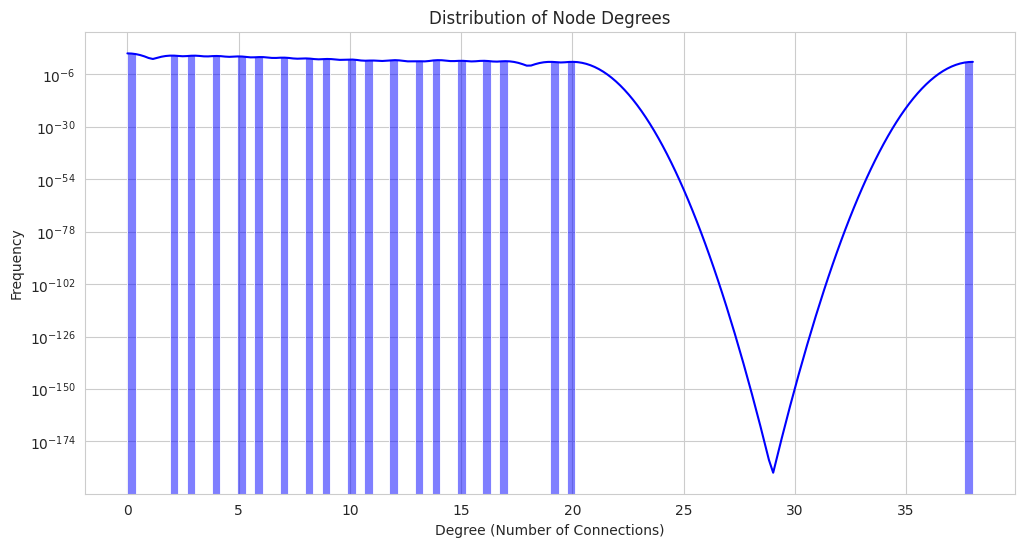

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Plot the distribution of node degrees
plt.figure(figsize=(12, 6))
sns.histplot(total_degree, bins=100, kde=True, color='blue')
plt.title('Distribution of Node Degrees')
plt.xlabel('Degree (Number of Connections)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

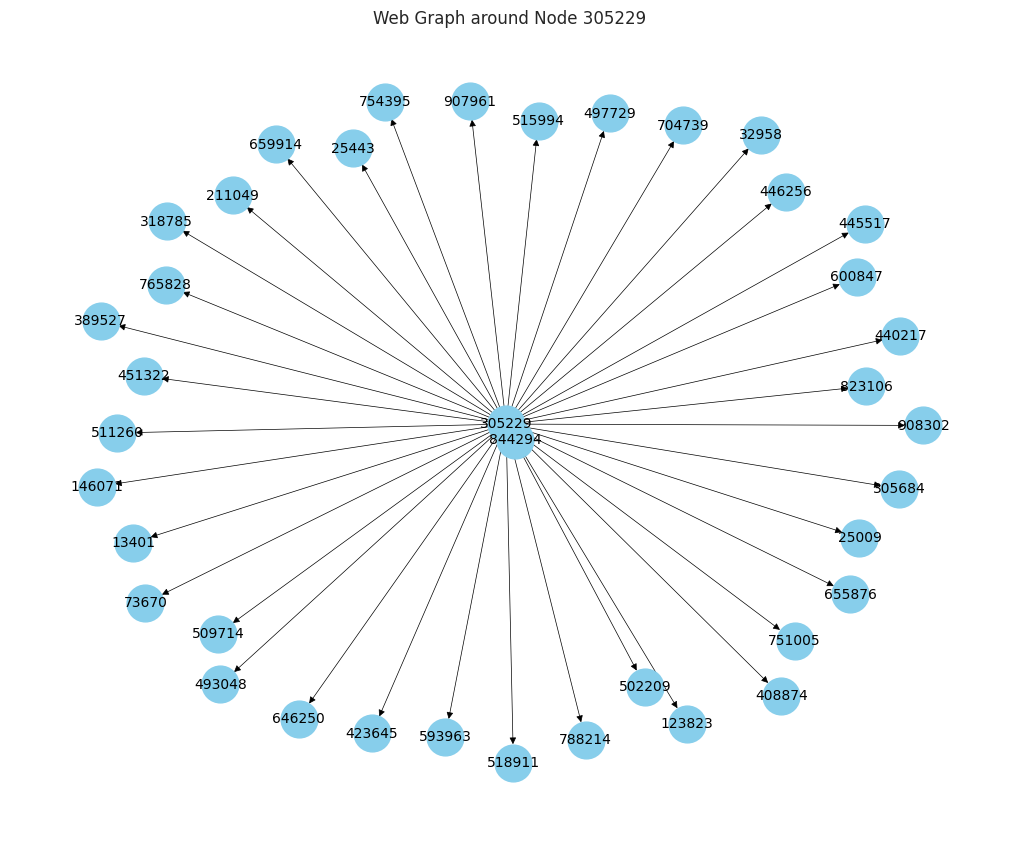

In [ ]:
import networkx as nx

# Initialize a graph
G = nx.DiGraph()

# Select a central node
central_node = top_5_nodes.index[0]

# Extract edges related to the central node
sample_edges = reduced_data[(reduced_data['Source'] == central_node) | (reduced_data['Target'] == central_node)]

# Add edges to the graph
G.add_edges_from(sample_edges.values)

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, width=0.5)
plt.title(f'Web Graph around Node {central_node}')
plt.show()

In [ ]:
# Reconstruct the graph from the reduced dataset
graph = nx.from_pandas_edgelist(reduced_data, 'Source', 'Target', create_using=nx.Graph())

# Apply Greedy Modularity Community Detection
communities_greedy = list(nx.algorithms.community.greedy_modularity_communities(graph))

# Analyze the resulting clusters
community_sizes_greedy = [len(community) for community in communities_greedy]

community_sizes_greedy

[120,
 116,
 113,
 109,
 108,
 95,
 91,
 88,
 82,
 81,
 79,
 79,
 78,
 77,
 77,
 67,
 67,
 65,
 65,
 64,
 64,
 62,
 62,
 59,
 57,
 56,
 55,
 55,
 55,
 55,
 54,
 50,
 48,
 47,
 46,
 44,
 44,
 44,
 43,
 41,
 40,
 40,
 37,
 37,
 36,
 36,
 36,
 35,
 35,
 35,
 34,
 32,
 32,
 32,
 30,
 29,
 29,
 29,
 28,
 27,
 26,
 25,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 9,
 9,
 9,
 9,
 9,
 9,
 

In [ ]:
# Calculate average degree for each community
community_avg_degrees = {}
for i, community in enumerate(communities_greedy):
    subgraph = graph.subgraph(community)
    avg_degree = sum(dict(subgraph.degree()).values()) / len(community)
    community_avg_degrees[i] = avg_degree

# Identify nodes that deviate significantly from their community's average degree
outliers = []
threshold = 2.0  # Nodes with degree > 2x the average of their community

for i, community in enumerate(communities_greedy):
    subgraph = graph.subgraph(community)
    for node, degree in subgraph.degree():
        if degree > threshold * community_avg_degrees[i]:
            outliers.append(node)

# Number of identified outlier nodes
num_outliers = len(outliers)
num_outliers

565

In [ ]:
import random

# Number of positive samples (existing links)
num_positive_samples = len(reduced_data)

# Generate negative samples
negative_samples = set()
while len(negative_samples) < num_positive_samples:
    node1, node2 = random.sample(graph.nodes(), 2)
    if not graph.has_edge(node1, node2):
        negative_samples.add((node1, node2))

# Compute features for both positive and negative samples
def compute_features(node_pairs, graph):
    features = []
    for node1, node2 in node_pairs:
        common_neighbors = len(list(nx.common_neighbors(graph, node1, node2)))
        jaccard_coeff = list(nx.jaccard_coefficient(graph, [(node1, node2)]))[0][2]
        adamic_adar = list(nx.adamic_adar_index(graph, [(node1, node2)]))[0][2]
        features.append([common_neighbors, jaccard_coeff, adamic_adar])
    return features

# Positive samples features
positive_features = compute_features(reduced_data.values, graph)

# Negative samples features
negative_features = compute_features(negative_samples, graph)

len(positive_features), len(negative_features)


<ipython-input-16-90276badf675>:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  node1, node2 = random.sample(graph.nodes(), 2)


(10000, 10000)

In [ ]:
import random

# Number of positive samples (existing links)
num_positive_samples = len(reduced_data)

# Generate negative samples
negative_samples = set()
while len(negative_samples) < num_positive_samples:
    node1, node2 = random.sample(graph.nodes(), 2)
    if not graph.has_edge(node1, node2):
        negative_samples.add((node1, node2))

# Compute features for both positive and negative samples
def compute_features(node_pairs, graph):
    features = []
    for node1, node2 in node_pairs:
        common_neighbors = len(list(nx.common_neighbors(graph, node1, node2)))
        jaccard_coeff = list(nx.jaccard_coefficient(graph, [(node1, node2)]))[0][2]
        adamic_adar = list(nx.adamic_adar_index(graph, [(node1, node2)]))[0][2]
        features.append([common_neighbors, jaccard_coeff, adamic_adar])
    return features

# Positive samples features
positive_features = compute_features(reduced_data.values, graph)

# Negative samples features
negative_features = compute_features(negative_samples, graph)

len(positive_features), len(negative_features)


<ipython-input-17-90276badf675>:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  node1, node2 = random.sample(graph.nodes(), 2)


(10000, 10000)

In [ ]:
from sklearn.model_selection import train_test_split

# Combine the features and labels
X = positive_features + negative_features
y = [1] * num_positive_samples + [0] * num_positive_samples

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test)


(16000, 4000)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep


(0.572,
 '              precision    recall  f1-score   support\n\n           0       0.54      1.00      0.70      1981\n           1       1.00      0.15      0.26      2019\n\n    accuracy                           0.57      4000\n   macro avg       0.77      0.58      0.48      4000\nweighted avg       0.77      0.57      0.48      4000\n')

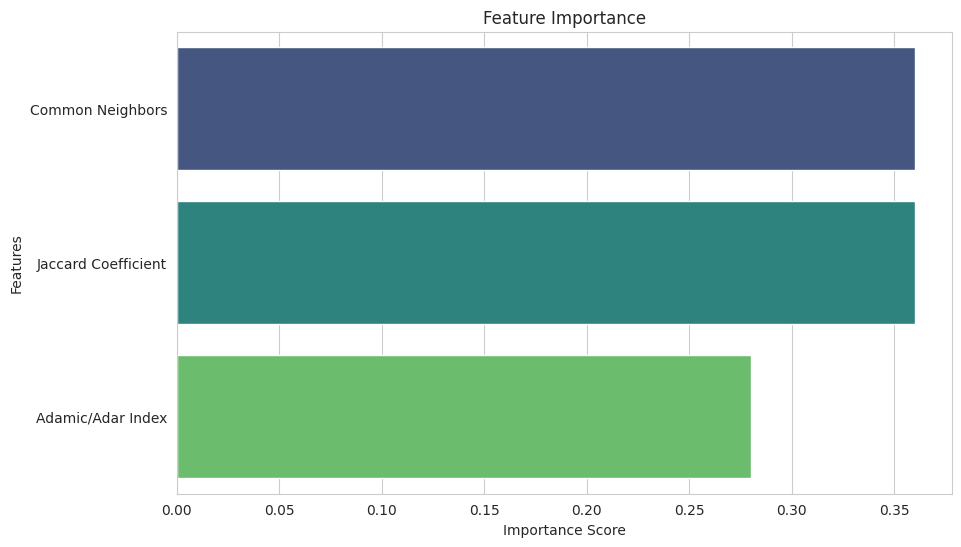

In [ ]:
# Extract feature importance from the Random Forest classifier
feature_importance = clf.feature_importances_

# Features used for the classifier
features = ["Common Neighbors", "Jaccard Coefficient", "Adamic/Adar Index"]

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features, palette="viridis")
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


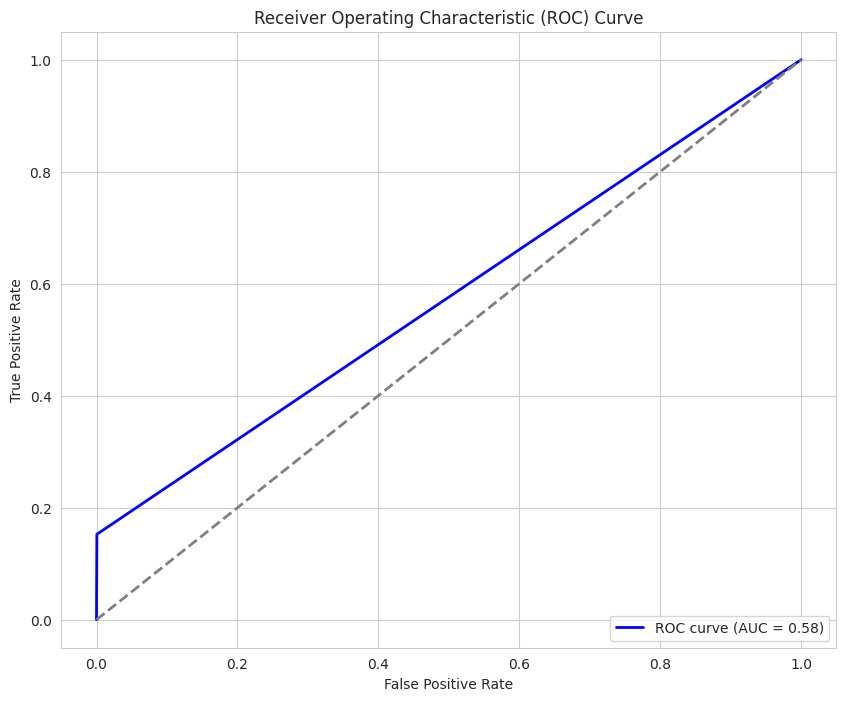

0.5760229860744931

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the probabilities of the positive class
y_prob = clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

roc_auc
